<a href="https://colab.research.google.com/github/PKpacheco/intro_ai_project2/blob/main/project_2_intro_ai_Paola_Pacheco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Project 2: Random Forests and Ensembles
Intro to AI
\
Instructor: Jeffrey Lanyon
\
Student: Paola Katherine Pacheco


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV
    )
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate





## Question 1

In [3]:
# import files
path_image_attr_abels = '/content/drive/MyDrive/Colab Notebooks/intro to ai/CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt'
path_class_labels = '/content/drive/MyDrive/Colab Notebooks/intro to ai/CUB_200_2011/CUB_200_2011/image_class_labels.txt'

In [4]:
# read 1st file
imgatt = pd.read_csv(path_image_attr_abels,  sep='\s+', usecols=[0, 1, 2], on_bad_lines='skip')
imgatt.columns = ["imgid", "attid", "present"]
imgatt.head()


,imgid,attid,present
0,1,2,0
1,1,3,0
2,1,4,0
3,1,5,1
4,1,6,0


In [5]:
imgatt.describe()

,imgid,attid,present
count,3.677855e+06,3.677855e+06,3.677855e+06
mean,5.894502e+03,1.565000e+02,1.008868e-01
std,3.402902e+03,9.006617e+01,3.011788e-01
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,2.948000e+03,7.900000e+01,0.000000e+00
50%,5.895000e+03,1.570000e+02,0.000000e+00
75%,8.841500e+03,2.345000e+02,0.000000e+00
max,1.178800e+04,3.120000e+02,1.000000e+00


In [6]:
# read 2nd file
imglabels = pd.read_csv(path_class_labels, header=None, sep='\s+', on_bad_lines='skip')
imglabels.columns = ["imgid", "label"]
imglabels.head()

,imgid,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [7]:
imglabels.describe()

,imgid,label
count,11788.000000,11788.000000
mean,5894.500000,101.126315
std,3403.046821,57.476826
min,1.000000,1.000000
25%,2947.750000,51.000000
50%,5894.500000,101.000000
75%,8841.250000,151.000000
max,11788.000000,200.000000


In [8]:
print("Shape of image_attribute_labels.txt :", imgatt.shape)
print("Shape of image_class_labels.txt :", imglabels.shape)

Shape of image_attribute_labels.txt : (3677855, 3)
Shape of image_class_labels.txt : (11788, 2)


In [9]:
# Check  duplicate
imgatt.drop_duplicates(inplace=True)

## Question 1.3 Data Transformation

In [10]:
# Pivot the data to wide format
imgatt2 = imgatt.pivot(index='imgid', columns='attid', values='present')

In [11]:
# Output the head of the new arrangement
print("------> head imgatt2:")
print("")
print(imgatt2.head())

# number of rows and columns
num_rows, num_columns = imgatt2.shape
print(f"------> Number of rows: {num_rows}")
print(f"------> Number of columns: {num_columns}")

------> head imgatt2:

attid  1    2    3    4    5    6    7    8    9    10   ...  303  304  305  \
imgid                                                    ...                  
1      NaN  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5      0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0   

attid  306  307  308  309  310  311  312  
imgid                                     
1      0.0  0.0  1.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  1.0  0.0  0.0  1.0  0.0  
4      1.0  0.0  0.0  1.0  0.0  0.0  0.0  
5      0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 312 columns]
------> Number of rows: 11788
------> Number of columns: 312


In [12]:
# Check duplicates
imgatt2.drop_duplicates(inplace=True)
imglabels.drop_duplicates(inplace=True)

In [13]:
# Check Nan
imgatt2.dropna(inplace=True)
imglabels.dropna(inplace=True)

## Question 1.4 Data Merging and Shuffle

In [14]:
# define new index to imigid
imglabels.set_index("imgid", inplace=True)

In [15]:
# Merge the two dataframes using the column "imgid"
merged_df = pd.merge(imgatt2, imglabels, on="imgid")

In [16]:
# Randomly shuffle the df
shuffled_data = merged_df.sample(frac=1, random_state=10)

In [17]:
# Split df into attributes and labels
attributes = shuffled_data.iloc[:, :-1]
labels = shuffled_data.iloc[:, -1]

In [18]:
# Convert to numpy arrays
attributes_np_array = attributes.values
labels_np_array = labels.values

In [19]:
# flatten the labels
labels_flatten = labels_np_array.flatten()

In [20]:
print("Shape of attributes_array:", attributes_np_array.shape)
print("Shape of labels_array:", labels_flatten.shape)

Shape of attributes_array: (11756, 312)
Shape of labels_array: (11756,)


## Question 2 Training and Testing Sets

In [21]:
# Split the data into training and testing sets, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(attributes_np_array, labels_flatten, test_size=0.2, random_state=42)

In [22]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (9404, 312)
Shape of X_test: (2352, 312)
Shape of y_train: (9404,)
Shape of y_test: (2352,)


## Question 3 Random Forest Classifier

In [23]:
# Random Forest classifier with  max features=15, and 25 trees
rf_classifier = RandomForestClassifier(max_features=15, n_estimators=25, random_state=42)

# tranining
rf_classifier.fit(X_train, y_train)

# predict labels on the training and testing data
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

#  training and testing accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [24]:
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 1.0
Testing Accuracy: 0.4013605442176871


The Random Forest Classifier has a training accuracy of 100%, which means that this model is perfectly fitting the training data. However, when the same model runs with test data the accuracy is much lower, 40.13%, this is possibly due to overfitting in the training data. The model learned very well from the training data but does not work with new data.

## Question 4 Confusion Matrix

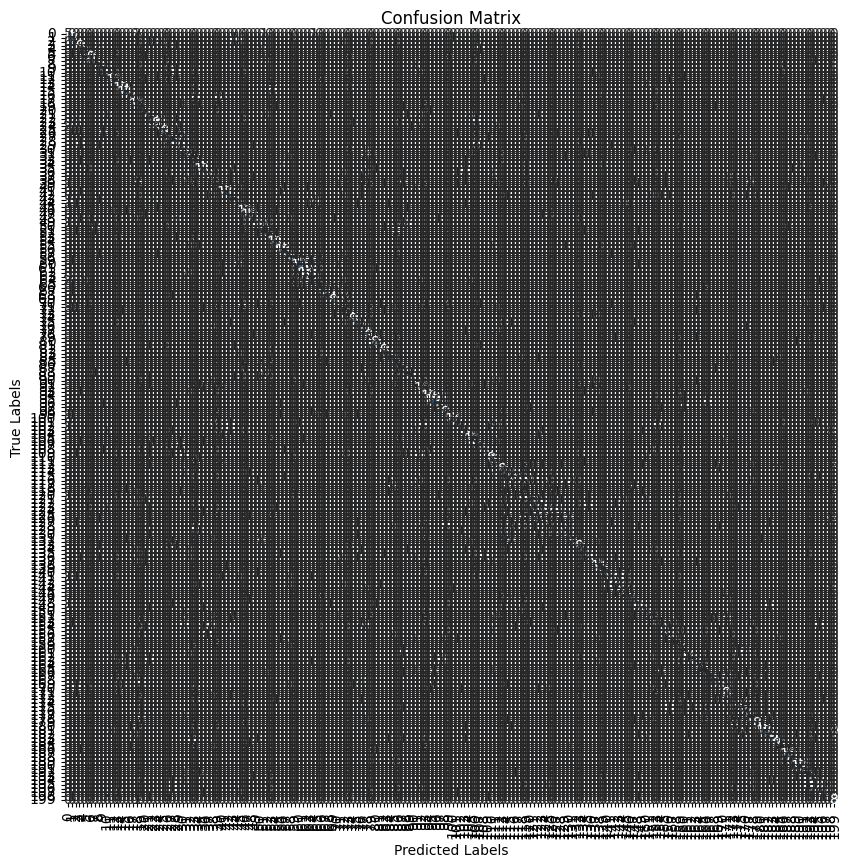

In [25]:
# confusion matrix for testing data
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=True, yticklabels=True, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


As we can see, the confusion matrix has so many values and that is why there are overlapping values. Let's try a different way to plot the confusion matrix

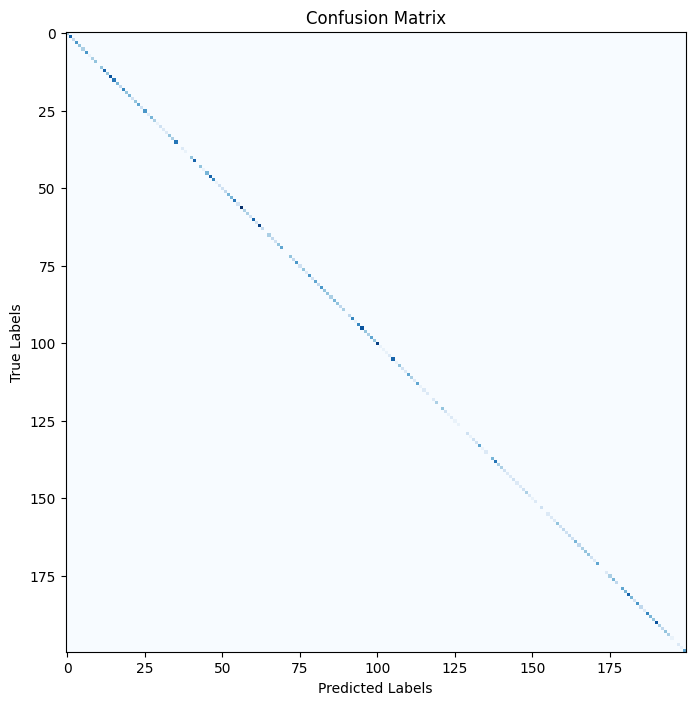

In [26]:
plt.figure(figsize=(8, 10))

# Plot the diagonal with a different color
plt.imshow(np.diag(np.diag(conf_matrix)), cmap='Blues', interpolation='nearest')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

## Question 5 Model Comparisons

### KNN

In [27]:
# find the best k to put in the model (values from 1 to 29)
k_values = list(range(1, 30))

mean_accuracy_scores = []

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    #  cross-validation with 5 folds
    scores = cross_val_score(knn_classifier, X_train, y_train, cv=5, scoring='accuracy')

    mean_accuracy = scores.mean()

    mean_accuracy_scores.append(mean_accuracy)

best_k = k_values[mean_accuracy_scores.index(max(mean_accuracy_scores))]

print("Best k:", best_k)


Best k: 14


In [28]:
results_bestk = pd.DataFrame({'k': k_values, 'Mean Accuracy': mean_accuracy_scores})

print(results_bestk)

     k  Mean Accuracy
0    1       0.305190
1    2       0.280520
2    3       0.290835
3    4       0.303276
4    5       0.315185
5    6       0.319120
6    7       0.326457
7    8       0.324649
8    9       0.326990
9   10       0.326776
10  11       0.328265
11  12       0.326246
12  13       0.328584
13  14       0.330923
14  15       0.327308
15  16       0.327095
16  17       0.327202
17  18       0.324863
18  19       0.326245
19  20       0.321885
20  21       0.321885
21  22       0.322204
22  23       0.321035
23  24       0.323373
24  25       0.319227
25  26       0.320502
26  27       0.320609
27  28       0.317631
28  29       0.319864


In [29]:
# model KNN  with k = 14, defined as a best k in the code before
knn_classifier = KNeighborsClassifier(n_neighbors=14)

# train the KNN
knn_classifier.fit(X_train, y_train)

# run the KNN with testing data
y_train_pred_knn = knn_classifier.predict(X_train)
y_test_pred_knn = knn_classifier.predict(X_test)


#  training and testing accuracies
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)


In [30]:
print("Training Accuracy knn:", train_accuracy_knn)
print("Testing Accuracy knn:", test_accuracy_knn)

Training Accuracy knn: 0.45714589536367506
Testing Accuracy knn: 0.3307823129251701


### Decision Tree

In [31]:
# model without hyperparameters
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

# traning
decision_tree_classifier.fit(X_train, y_train)

# run the decision tree with testing data
y_train_pred_dt = decision_tree_classifier.predict(X_train)
y_test_pred_dt = decision_tree_classifier.predict(X_test)

#  training and testing accuracies
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)

In [32]:
print("Training Accuracy dt:", train_accuracy_dt)
print("Testing Accuracy dt:", test_accuracy_dt)

Training Accuracy dt: 1.0
Testing Accuracy dt: 0.2699829931972789


In [33]:
max_depth_values = [5, 10, 15]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

results_all_dt = pd.DataFrame(columns=["max_depth", "min_samples_split", "min_samples_leaf", "Train Accuracy", "Test Accuracy"])

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:
            decision_tree_classifier = DecisionTreeClassifier(
                random_state=42,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf
            )

            # training
            decision_tree_classifier.fit(X_train, y_train)

            # prediction training data
            y_train_pred = decision_tree_classifier.predict(X_train)

            # accuracy training data
            train_accuracy = accuracy_score(y_train, y_train_pred)

            # prediction testing data
            y_test_pred = decision_tree_classifier.predict(X_test)

            # accuracy testing data
            test_accuracy = accuracy_score(y_test, y_test_pred)

            results_all_dt = results_all_dt.append({"max_depth": max_depth,
                                            "min_samples_split": min_samples_split,
                                            "min_samples_leaf": min_samples_leaf,
                                            "Train Accuracy": train_accuracy,
                                            "Test Accuracy": test_accuracy}, ignore_index=True)

table_result_dt = tabulate(results_all_dt, headers='keys', tablefmt='pretty', showindex=False)

print(table_result_dt)

<ipython-input-33-7ed162446000>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_all_dt = results_all_dt.append({"max_depth": max_depth,
<ipython-input-33-7ed162446000>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_all_dt = results_all_dt.append({"max_depth": max_depth,
<ipython-input-33-7ed162446000>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_all_dt = results_all_dt.append({"max_depth": max_depth,
<ipython-input-33-7ed162446000>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_all_dt = results_all_dt.append({"max_depth": max_depth,
<ipython-input-33-7ed162446000>:32: FutureWarning: The frame

+-----------+-------------------+------------------+---------------------+---------------------+
| max_depth | min_samples_split | min_samples_leaf |   Train Accuracy    |    Test Accuracy    |
+-----------+-------------------+------------------+---------------------+---------------------+
|    5.0    |        2.0        |       1.0        | 0.0777328796256912  | 0.05442176870748299 |
|    5.0    |        2.0        |       2.0        | 0.07741386643981285 | 0.05357142857142857 |
|    5.0    |        2.0        |       4.0        | 0.07730752871118673 | 0.05442176870748299 |
|    5.0    |        5.0        |       1.0        | 0.0777328796256912  | 0.05442176870748299 |
|    5.0    |        5.0        |       2.0        | 0.07741386643981285 | 0.05357142857142857 |
|    5.0    |        5.0        |       4.0        | 0.07730752871118673 | 0.05442176870748299 |
|    5.0    |       10.0        |       1.0        | 0.0777328796256912  | 0.05442176870748299 |
|    5.0    |       10.0      

<ipython-input-33-7ed162446000>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_all_dt = results_all_dt.append({"max_depth": max_depth,


According to the hyperparameters, this is the best model
* max_depth = 15.0
* min_samples_split = 2.0
* min_samples_leaf = 1.0

* accuracy values:

* Train Accuracy: 0.4172692471288813
* Test Accuracy: 0.23001700680272108

In [34]:
# model with best hyperparameters
decision_tree_classifier_hyper = DecisionTreeClassifier(
    random_state=42,
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1
)

# Training the model with hyperparameters
decision_tree_classifier_hyper.fit(X_train, y_train)

y_train_pred_dt_hyper = decision_tree_classifier_hyper.predict(X_train)
y_test_pred_dt_hyper = decision_tree_classifier_hyper.predict(X_test)

train_accuracy_dt_hyper = accuracy_score(y_train, y_train_pred_dt_hyper)
test_accuracy_dt_hyper = accuracy_score(y_test, y_test_pred_dt_hyper)


In [35]:
print("------> Decision Tree Model with Hyperparameters:")
print("Training Accuracy (With Hyperparameters):", train_accuracy_dt_hyper)
print("Testing Accuracy (With Hyperparameters):", test_accuracy_dt_hyper)

------> Decision Tree Model with Hyperparameters:
Training Accuracy (With Hyperparameters): 0.4172692471288813
Testing Accuracy (With Hyperparameters): 0.23001700680272108


Compare the performance of the Random Forest, KNN, and Decision Tree models and report their accuracies.

In [36]:
# Print the test accuracies for all three models
print("----------> Random Forest")
print("Random Forest Training Accuracy:", train_accuracy)
print("Random Forest Test Accuracy:", test_accuracy)
print("")

print("----------> KNN")
print("KNN Training Accuracy:", train_accuracy_knn)
print("KNN Test Accuracy:", test_accuracy_knn)
print("")

print("----------> Decision Tree")
print("Decision Tree Training Accuracy:", train_accuracy_dt)
print("Decision Tree Test Accuracy:", test_accuracy_dt)
print("")

print("----------> Decision Tree with Hyperparameters")
print("Decision Tree Training hyper Accuracy:", train_accuracy_dt_hyper)
print("Decision Tree Test hyper Accuracy:", test_accuracy_dt_hyper)


----------> Random Forest
Random Forest Training Accuracy: 0.33719693747341556
Random Forest Test Accuracy: 0.23171768707482993

----------> KNN
KNN Training Accuracy: 0.45714589536367506
KNN Test Accuracy: 0.3307823129251701

----------> Decision Tree
Decision Tree Training Accuracy: 1.0
Decision Tree Test Accuracy: 0.2699829931972789

----------> Decision Tree with Hyperparameters
Decision Tree Training hyper Accuracy: 0.4172692471288813
Decision Tree Test hyper Accuracy: 0.23001700680272108


Comments:

* Random Forest


The Random Forest model exhibits a high training accuracy that can be considered (overfitting) specially because the test data have a low acuracy, but its testing accuracy is the highest among the three models when comparing the other models.


* K-nearest neighbors (KNN)


The KNN model has moderate training accuracy and slightly lower testing accuracy than Random Forest. This suggests that KNN may not be the best choice for this dataset.


* Decision tree


The Decision Tree model demonstrates high training accuracy that can be considered (overfitting) and lower testing accuracy among the three models, indicating poor generalization.


* Decision Tree with hyperparameters

The Decision Tree model with hyperparameters shows improved testing accuracy compared to the Decision Tree without hyperparameters and we can't see overfitting. However, it still behind the Random Forest and KNN models in terms of testing accuracy.


## Question 6 Cross-Validation

In [37]:
# Define the models (assuming you've already trained them)
models = [
    ("Random Forest", rf_classifier),
    ("KNN", knn_classifier),
    ("Decision Tree", decision_tree_classifier),
    ("Decision Tree hyperparameter", decision_tree_classifier_hyper),

]

#  5-fold cross-validation for each model
for model_name, model in models:
    cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    # average accuracy and standard deviation
    avg_accuracy = np.mean(cross_val_scores)
    std_accuracy = np.std(cross_val_scores)

    print(f"Model: {model_name}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Standard Deviation: {std_accuracy:.4f}")
    print()

Model: Random Forest
Average Accuracy: 0.3895
Standard Deviation: 0.0105

Model: KNN
Average Accuracy: 0.3309
Standard Deviation: 0.0061

Model: Decision Tree
Average Accuracy: 0.2202
Standard Deviation: 0.0081

Model: Decision Tree hyperparameter
Average Accuracy: 0.2148
Standard Deviation: 0.0092



The Random Forest model has the highest average accuracy, followed by KNN. Both Decision Tree models have lower average accuracies, with the Decision Tree without hyperparameters having a slightly higher average accuracy.

\
The lower standard deviations indicate that there was not much difference in cross validation, the performance was constant and consistent.

\

Evaluating the models, Random Forest appears to be the best based on average accuracy and lowest standard deviation

## Question 7 Hyperparameter Tuning

In [38]:
# # parameter grid for max_features(5 to 50 in steps of 5) and n_estimators( 10 to 200 in steps of 10)
# # takes a LONG time to execute
# param_grid = {
#     'max_features': np.arange(5, 51, 5),
#     'n_estimators': np.arange(10, 201, 10)
# }

In [39]:
# Reduced parameter grid for max_features and n_estimators due to time taken to run
param_grid = {
    'max_features': [5, 10, 15, 20],
    'n_estimators': [50, 100, 150]
}

In [40]:
# create random forest classifier number 2
rf_classifier_2 = RandomForestClassifier(random_state=42)

In [41]:
# create GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier_2, param_grid=param_grid, cv=5, scoring='accuracy')

# fit grid search to traning data
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_features': [5, 10, 15, 20],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [42]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_features': 10, 'n_estimators': 150}


In [43]:
# Extract grid search results
results = grid_search.cv_results_
max_features_values = results['param_max_features']
n_estimators_values = results['param_n_estimators']
accuracies = results['mean_test_score']

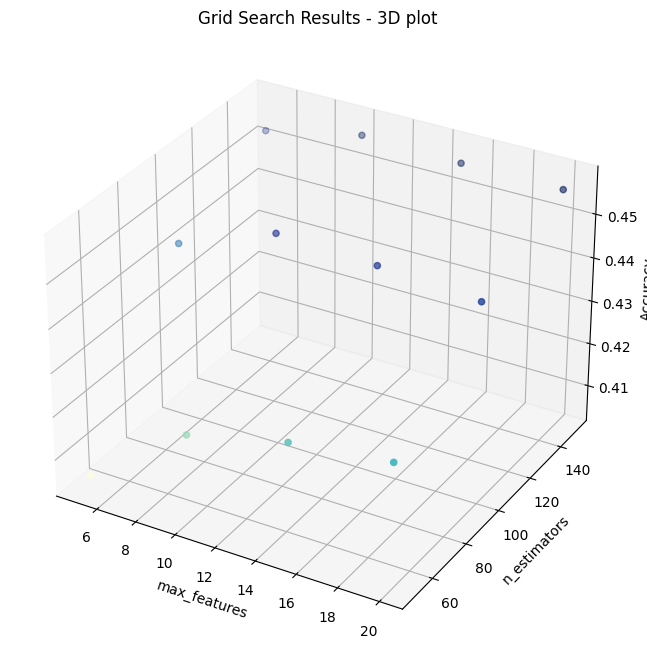

In [44]:
# Create a 3D  plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(max_features_values, n_estimators_values, accuracies, c=accuracies, cmap='YlGnBu')

# Set axis labels
ax.set_xlabel('max_features')
ax.set_ylabel('n_estimators')
ax.set_zlabel('Accuracy')

plt.title('Grid Search Results - 3D plot')
plt.show()


In [45]:
# best parameters
best_max_features = best_params['max_features']
best_n_estimators = best_params['n_estimators']

rf_classifier_optimized = RandomForestClassifier(max_features=best_max_features, n_estimators=best_n_estimators, random_state=42)
rf_classifier_optimized.fit(X_train, y_train)

# predict
y_train_pred_rf_optimized = rf_classifier_optimized.predict(X_train)
y_test_pred_rf_optimized = rf_classifier_optimized.predict(X_test)

# Calculate the accuracy of the optimized Random Forest model
accuracy_rf_optimized_train = accuracy_score(y_train, y_train_pred_rf_optimized)
accuracy_rf_optimized_test = accuracy_score(y_test, y_test_pred_rf_optimized)

In [46]:
# Output the test results for the optimized model
print("Optimized Random Forest Train Accuracy:", accuracy_rf_optimized_train)
print("Optimized Random Forest Test Accuracy:", accuracy_rf_optimized_test)

Optimized Random Forest Train Accuracy: 1.0
Optimized Random Forest Test Accuracy: 0.46938775510204084


## Question 8 Stacking Ensemble

In [47]:
# initialize base learners
base_learners = [
    ('DecisionTree', DecisionTreeClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(kernel='linear', random_state=42))
]

# init stacking ensemble with a random forest as the meta-model
stacking_ensemble = RandomForestClassifier(random_state=42)

# train base learners on the training data
for learner_name, learner_model in base_learners:
    learner_model.fit(X_train, y_train)

# predictions from base learners for training and test data
train_predictions = []
test_predictions = []
for learner_name, learner_model in base_learners:
    train_predictions.append(learner_model.predict(X_train))
    test_predictions.append(learner_model.predict(X_test))

#  predictions for training and test data
X_train_stacked = np.column_stack(train_predictions)
X_test_stacked = np.column_stack(test_predictions)

# train the meta-model on the stacked features
stacking_ensemble.fit(X_train_stacked, y_train)

#  predictions on the test data using the stacking ensemble
y_test_pred_stacking = stacking_ensemble.predict(X_test_stacked)

# accuracy of the stacking ensemble on the test data
accuracy_stacking = accuracy_score(y_test, y_test_pred_stacking)

print("Stacking Ensemble Test Accuracy:", accuracy_stacking)


Stacking Ensemble Test Accuracy: 0.3494897959183674


In [48]:
all_results = [
    ["Random Forest ", test_accuracy],
    ["Random Forest Optimized", accuracy_rf_optimized_test],
    ["KNN", test_accuracy_knn],
    ["Decision Tree", test_accuracy_dt],
    ["Decision Tree with hyperp", test_accuracy_dt_hyper],
    ["Stacking Ensemble", accuracy_stacking]
]

# Create a table with the results
table = tabulate(all_results, headers=["Model", "Test Accuracy"], tablefmt="grid")

# Display the table
print(table)


+---------------------------+-----------------+
| Model                     |   Test Accuracy |
+===========================+=================+
| Random Forest             |        0.231718 |
+---------------------------+-----------------+
| Random Forest Optimized   |        0.469388 |
+---------------------------+-----------------+
| KNN                       |        0.330782 |
+---------------------------+-----------------+
| Decision Tree             |        0.269983 |
+---------------------------+-----------------+
| Decision Tree with hyperp |        0.230017 |
+---------------------------+-----------------+
| Stacking Ensemble         |        0.34949  |
+---------------------------+-----------------+


## Question 9 Improve Performance

In [49]:

# Define base learners
best_knn_classifier = KNeighborsClassifier(n_neighbors=14, weights='distance', algorithm='auto')
best_svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
best_decision_tree_classifier = DecisionTreeClassifier(max_depth=15, min_samples_split=2, min_samples_leaf=1, random_state=42)

# Initialize a Random Forest as the meta-model with hyperparameter tuning
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': [5, 10, 15, 20]
}
rf_classifier = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_classifier, param_grid=rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train_stacked, y_train)
best_rf_params = rf_grid_search.best_params_
best_rf_classifier = RandomForestClassifier(random_state=42, **best_rf_params)

# Create a Stacking Ensemble with the best base learners and the tuned Random Forest
stacking_ensemble = StackingClassifier(
    estimators=[
        ('KNN', best_knn_classifier),
        ('SVM', best_svm_classifier),
        ('DecisionTree', best_decision_tree_classifier)
    ],
    final_estimator=best_rf_classifier,
    stack_method='auto',
    n_jobs=-1
)

# Train the Stacking Ensemble
stacking_ensemble.fit(X_train, y_train)

# Make predictions with the ensemble on the test data
y_test_pred_stacking_tuned = stacking_ensemble.predict(X_test)

# Calculate the accuracy of the tuned stacking ensemble
accuracy_stacking_tuned = accuracy_score(y_test, y_test_pred_stacking_tuned)
print("Tuned Stacking Ensemble Test Accuracy:", accuracy_stacking_tuned)


Tuned Stacking Ensemble Test Accuracy: 0.4145408163265306


In [50]:
all_results = [
    ["Random Forest ", test_accuracy],
    ["Random Forest Optimized", accuracy_rf_optimized_test],
    ["KNN", test_accuracy_knn],
    ["Decision Tree", test_accuracy_dt],
    ["Decision Tree with hyperp", test_accuracy_dt_hyper],
    ["Stacking Ensemble", accuracy_stacking],
    ["Stacking Ensemble Tuned", accuracy_stacking_tuned]

]

# Create a table with the results
table = tabulate(all_results, headers=["Model", "Test Accuracy"], tablefmt="grid")

# Display the table
print(table)


+---------------------------+-----------------+
| Model                     |   Test Accuracy |
+===========================+=================+
| Random Forest             |        0.231718 |
+---------------------------+-----------------+
| Random Forest Optimized   |        0.469388 |
+---------------------------+-----------------+
| KNN                       |        0.330782 |
+---------------------------+-----------------+
| Decision Tree             |        0.269983 |
+---------------------------+-----------------+
| Decision Tree with hyperp |        0.230017 |
+---------------------------+-----------------+
| Stacking Ensemble         |        0.34949  |
+---------------------------+-----------------+
| Stacking Ensemble Tuned   |        0.414541 |
+---------------------------+-----------------+


Even after tuning the stacking ensemb;e, the accuracy did not have a significant increase, just a slight increase in its value